In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import cv2

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,BatchNormalization,GlobalAveragePooling2D,Dense
from keras.layers import ReLU,LeakyReLU,Softmax
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.11.0-rc1


In [2]:
def shuffleList(lst):
    indicies = np.random.permutation(np.arange(len(lst)))
    return list(np.array(lst)[indicies])

def shufflePair(X,Y=None):
    indicies = np.random.permutation(np.arange(len(X)))
    X = X[indicies]
    if Y is not None:
        Y = Y[indicies]
    return X,Y

In [3]:
def readImg(imgPathList,targetShape):
    imgs = []
    for imgPath in imgPathList:
        if targetShape[2]==3:
            frame = cv2.imread(imgPath,cv2.IMREAD_COLOR)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        else:
            frame = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame,(targetShape[0],targetShape[1]))
        imgs.append(frame)
    return imgs
    

In [4]:
#dataHome = "/home/rajeev/Documents/DataSets/JBM/YE358311_Fender_apron"
dataHome = "../input/jbmdataset-color"

healthyDir = dataHome+"/YE358311_Healthy"
defectiveDir = dataHome+"/YE358311_defects/YE358311_Crack_and_Wrinkle_defect"

targetShape = (512,512,3)

In [ ]:
healthy_img_names = [ healthyDir+"/"+imgName for imgName in os.listdir(healthyDir)]
defective_img_names = [defectiveDir+"/"+imgName for imgName in os.listdir(defectiveDir)]

healthy_img_names = shuffleList(healthy_img_names)
defective_img_names = shuffleList(defective_img_names)

In [ ]:
healthy_X = np.array(readImg(healthy_img_names,targetShape)).astype(np.float32) / 255.0
healthy_Y = to_categorical(np.ones(len(healthy_img_names)),num_classes=2)

defective_X = np.array(readImg(defective_img_names,targetShape)).astype(np.float32) / 255.0
defective_Y = to_categorical(np.zeros(len(defective_img_names)),num_classes=2)


In [ ]:
# Save data.

if targetShape[2]==1:
    np.save(dataHome+"/healthy_X_gray.npy",healthy_X)
    np.save(dataHome+"/healthy_Y_gray.npy",healthy_Y)
    np.save(dataHome+"/defective_X_gray.npy",defective_X)
    np.save(dataHome+"/defective_Y_gray.npy",defective_Y)
else:
    np.save(dataHome+"/healthy_X.npy",healthy_X)
    np.save(dataHome+"/healthy_Y.npy",healthy_Y)
    np.save(dataHome+"/defective_X.npy",defective_X)
    np.save(dataHome+"/defective_Y.npy",defective_Y)

In [5]:
# Load data.

if targetShape[2]==1:
    healthy_X = np.load(dataHome+"/healthy_X_gray.npy")
    healthy_Y = np.load(dataHome+"/healthy_Y_gray.npy")
    defective_X = np.load(dataHome+"/defective_X_gray.npy")
    defective_Y = np.load(dataHome+"/defective_Y_gray.npy")
else:
    healthy_X = np.load(dataHome+"/healthy_X.npy")
    healthy_Y = np.load(dataHome+"/healthy_Y.npy")
    defective_X = np.load(dataHome+"/defective_X.npy")
    defective_Y = np.load(dataHome+"/defective_Y.npy")

In [7]:
healthy_X, healthy_Y  = shufflePair(healthy_X,healthy_Y)
defective_X, defective_Y = shufflePair(defective_X, defective_Y)

In [9]:
# Take 10% points from each healthy and defecti
val_len_healthy = int(len(healthy_X) * 0.10)
val_len_defective = int(len(defective_X) * 0.10)

val_X = np.concatenate((healthy_X[:val_len_healthy], defective_X[:val_len_defective]))
val_Y = np.concatenate((healthy_Y[:val_len_healthy], defective_Y[:val_len_defective]))

train_X = np.concatenate((healthy_X[val_len_healthy:], defective_X[val_len_defective:]))
train_Y = np.concatenate((healthy_Y[val_len_healthy:], defective_Y[val_len_defective:]))

train_X, train_Y = shufflePair(train_X,train_Y)
val_X, val_Y = shufflePair(val_X,val_Y)

In [10]:
# Add channel axis if images are grayscale.
if targetShape[2]==1:
    train_X = train_X[:,:,:,None]
    val_X = val_X[:,:,:,None]

print("Train images:",train_X.shape, train_Y.shape)
print("Val images:",val_X.shape, val_Y.shape)


Train images: (226, 512, 512, 3) (226, 2)
Val images: (24, 512, 512, 3) (24, 2)


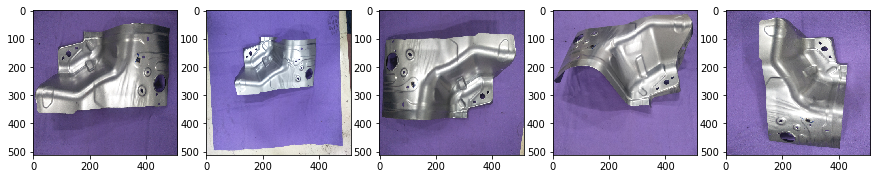

In [11]:
fig = plt.figure(figsize=(15,7))
for index,img in enumerate(train_X[:5]):
    plt.subplot(1,5,index+1)
    plotImg = (img*255).astype("uint8")
    if targetShape[2]==1:
        print(plotImg.shape)
        plt.imshow(plotImg[:,:,0],cmap="gray")
    else:
        plt.imshow(plotImg)


In [ ]:
#model = Sequential()
#act = LeakyReLU()

#model.add(Conv2D(32,(3,3),padding="same",use_bias=False,input_shape=targetShape))
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(64,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(128,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(256,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(512,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(512,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(1024,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(Conv2D(1024,(3,3),padding="same",use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(MaxPool2D((2,2),(2,2),padding="same"))
#model.add(Dropout(0.3))

#model.add(GlobalAveragePooling2D())

#model.add(Dense(1024,use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
#model.add(Dropout(0.3))

#model.add(Dense(1024,use_bias=False))
#model.add(BatchNormalization())
#model.add(act)
##model.add(Dropout(0.3))

#model.add(Dense(2,activation="softmax"))

#model.summary()


In [12]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

lastFixLayerName = "block5_pool"
#modelPrimary = ResNet50(include_top=False, weights='imagenet')
modelPrimary = VGG16(include_top=False, weights='imagenet')
for layer in modelPrimary.layers:
    if layer.name == lastFixLayerName:
        break
    if lastFixLayerName != "":
        layer.trainable = False
    
modelPrimary.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

In [13]:


model = Sequential()
model.add(modelPrimary)
model.add(GlobalAveragePooling2D())

model.add(Dense(512))
model.add(ReLU())
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(ReLU())

model.add(Dense(2,activation="softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)               0         
__________

In [14]:

opt = keras.optimizers.Adam()
#opt = keras.optimizers.RMSprop()
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [15]:
checkpoint  = ModelCheckpoint("JBM.hdf5",verbose=1)
lrReducer = ReduceLROnPlateau(patience=5,verbose=1)

In [16]:
trainDataGen = ImageDataGenerator(#rotation_range=45,
                                 #shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True)
valDataGen = ImageDataGenerator(rotation_range=45,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [17]:
epochs = 100
batch_size = 8
steps_per_epoch = int(len(train_X) / batch_size)

In [18]:
hist = model.fit_generator(trainDataGen.flow(train_X,train_Y,batch_size=batch_size),
                          steps_per_epoch = steps_per_epoch,
                          epochs = epochs,
                          callbacks=[lrReducer],
                          validation_data=(val_X,val_Y))

Epoch 1/100
37/37 [==============================] - 26s 691ms/step - loss: 0.7673 - acc: 0.5721 - val_loss: 0.7473 - val_acc: 0.5417
Epoch 2/100
37/37 [==============================] - 23s 629ms/step - loss: 0.7631 - acc: 0.5270 - val_loss: 0.6827 - val_acc: 0.5417
Epoch 3/100
37/37 [==============================] - 20s 547ms/step - loss: 0.6974 - acc: 0.5023 - val_loss: 0.6886 - val_acc: 0.5417
Epoch 4/100
37/37 [==============================] - 20s 545ms/step - loss: 0.6718 - acc: 0.6013 - val_loss: 0.9054 - val_acc: 0.5417
Epoch 5/100
37/37 [==============================] - 20s 542ms/step - loss: 0.7492 - acc: 0.4731 - val_loss: 0.6844 - val_acc: 0.7083
Epoch 6/100
37/37 [==============================] - 20s 542ms/step - loss: 0.6817 - acc: 0.6126 - val_loss: 0.7270 - val_acc: 0.5417
Epoch 7/100
37/37 [==============================] - 20s 543ms/step - loss: 0.6866 - acc: 0.5451 - val_loss: 0.6706 - val_acc: 0.5833
Epoch 8/100
37/37 [==============================] - 20s 543ms

37/37 [==============================] - 20s 543ms/step - loss: 0.3546 - acc: 0.8333 - val_loss: 0.3252 - val_acc: 0.9167
Epoch 62/100
37/37 [==============================] - 20s 543ms/step - loss: 0.3314 - acc: 0.8693 - val_loss: 0.3196 - val_acc: 0.9167
Epoch 63/100
37/37 [==============================] - 20s 544ms/step - loss: 0.3418 - acc: 0.8356 - val_loss: 0.3246 - val_acc: 0.8750
Epoch 64/100
37/37 [==============================] - 20s 542ms/step - loss: 0.3258 - acc: 0.8829 - val_loss: 0.3245 - val_acc: 0.9167
Epoch 65/100
37/37 [==============================] - 20s 545ms/step - loss: 0.3462 - acc: 0.8738 - val_loss: 0.3195 - val_acc: 0.8750
Epoch 66/100
37/37 [==============================] - 20s 542ms/step - loss: 0.3262 - acc: 0.8648 - val_loss: 0.3211 - val_acc: 0.8750
Epoch 67/100
37/37 [==============================] - 20s 544ms/step - loss: 0.3643 - acc: 0.8513 - val_loss: 0.3092 - val_acc: 0.9167
Epoch 68/100
37/37 [==============================] - 20s 544ms/step

In [ ]:
#hist = model.fit(trainDataGen.flow(train_X,train_Y,batch_size=batch_size),                          
#                          epochs = epochs,
#                          callbacks=[checkpoint,lrReducer],
#                          validation_data=(val_X,val_Y))

Text(0.5,1,'Accuracies')

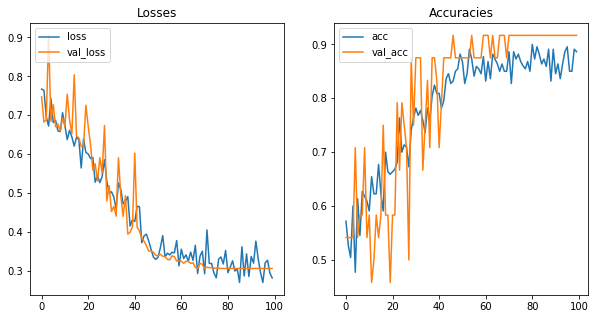

In [19]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend(loc="upper left")
plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(hist.history["acc"],label="acc")
plt.plot(hist.history["val_acc"],label="val_acc")
plt.legend(loc="upper left")
plt.title("Accuracies")

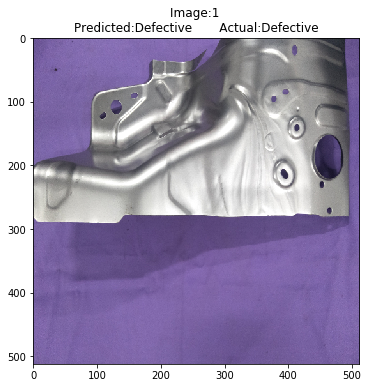

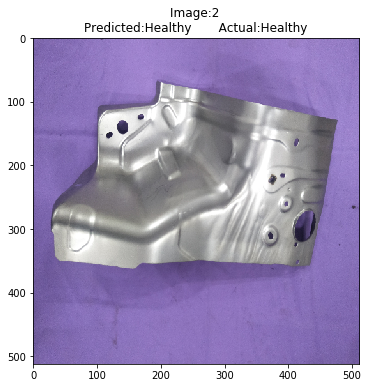

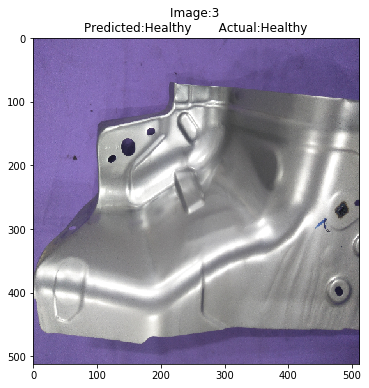

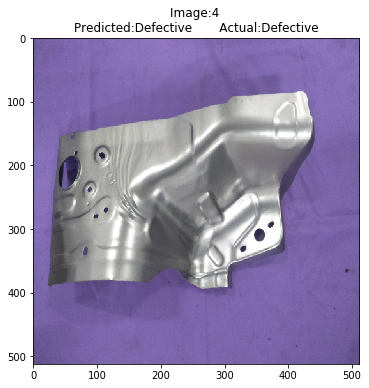

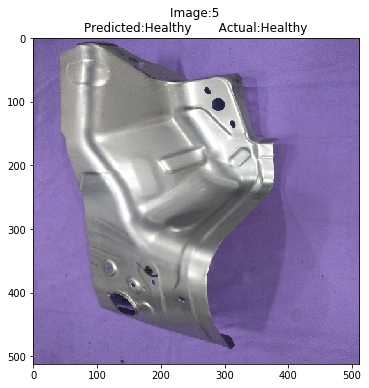

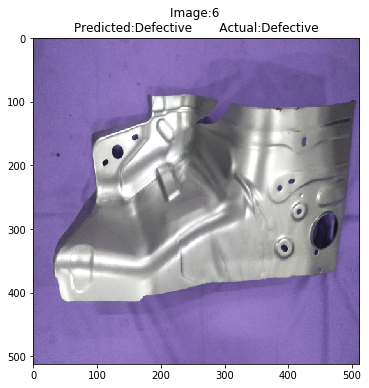

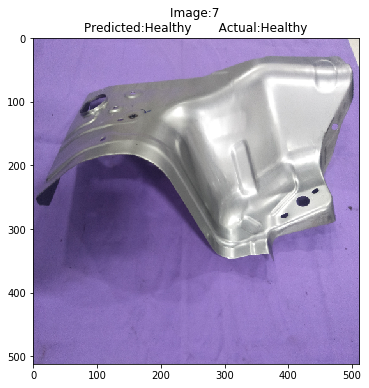

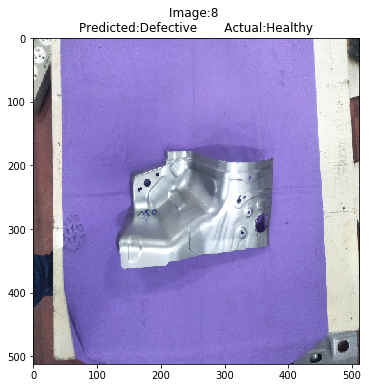

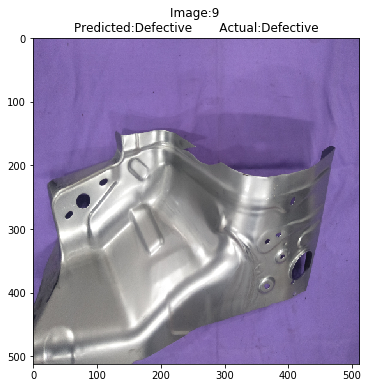

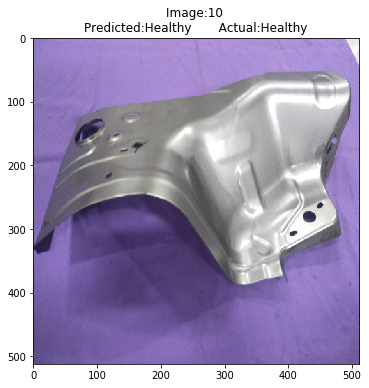

In [35]:
# Prediction output.
pred_out = model.predict(val_X)
pred_class = np.argmax(pred_out, axis=1)
actual_class = np.argmax(val_Y, axis=1)

class_names = {
    1:"Healthy",
    0:"Defective"
}

for i in range(10):
    fig = plt.figure(figsize=(6,6))
    #print("Actual:",class_names[actual_class[i]]," Predicted:",class_names[pred_class[i]])
    plotImg = (val_X[i]*255).astype(np.uint8)
    if targetShape[2]==1:
        plt.imshow(plotImg[:,:,0],cmap="gray")
    else:
        plt.imshow(plotImg)
    plt.title("Image:{} \nPredicted:{}       Actual:{}".format(i+1,class_names[pred_class[i]],class_names[actual_class[i]]))
    plt.show()